In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import keras_tuner as kt

In [3]:
# Load the dataset
df_total = pd.read_csv('Daily_Power_Gen_Source_march_23.csv')
df_total['date'] = pd.to_datetime(df_total['date'])
df_total.set_index('date', inplace=True)

# Extract target column 'All India' for energy consumption
y = df_total['All India'].values

# Normalize the target column
scaler = MinMaxScaler(feature_range=(0, 1))
y_normalized = scaler.fit_transform(y.reshape(-1, 1))

# Function to create sequences for model input
def create_dataset(X, look_back=1):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(X[i])
    return np.array(Xs), np.array(ys)

# Define look_back period for mid-term and long-term forecasting
look_back_mid = 90  # Example: 3 months for mid-term
look_back_long = 365  # Example: 1 year for long-term

# Create datasets for mid-term and long-term forecasting
X_mid, y_mid = create_dataset(y_normalized, look_back_mid)
X_long, y_long = create_dataset(y_normalized, look_back_long)

C:\Users\raaje\AppData\Local\Temp\ipykernel_1792\3697113600.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_total['date'] = pd.to_datetime(df_total['date'])


In [4]:
# Function to create a hybrid CNN-GRU-FFNN model with hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # CNN Layer with hyperparameter tuning for the number of filters
    model.add(Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=16), 
                     kernel_size=hp.Int('kernel_size', min_value=2, max_value=4, step=1), 
                     activation='relu', 
                     input_shape=(look_back_mid, 1)))
    model.add(MaxPooling1D(pool_size=2))

    # GRU Layer with hyperparameter tuning for the number of units
    model.add(GRU(hp.Int('gru_units', min_value=20, max_value=100, step=20), return_sequences=False))

    # FFNN Layers with hyperparameter tuning for dropout
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # Compile model with learning rate tuning
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'])
    return model

In [5]:
# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,  # Number of different models to try
    executions_per_trial=2,  # Number of executions per trial to average results
    directory='tuner_dir',
    project_name='energy_forecasting_tuning'
)

# Perform the search for the best model on the mid-term data
tuner.search(X_mid, y_mid, epochs=30, validation_split=0.2)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 09m 53s]
val_mean_squared_error: 0.08449175208806992

Best val_mean_squared_error So Far: 0.08407139033079147
Total elapsed time: 01h 34m 37s


C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


568/568 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
Mid-Term Forecasting with Tuned Hybrid CNN-GRU-FFNN - MSE: 1424499.6679, RMSE: 1193.5241, MAE: 931.1917, MAPE: 462.13%, MAD: 1158.6219


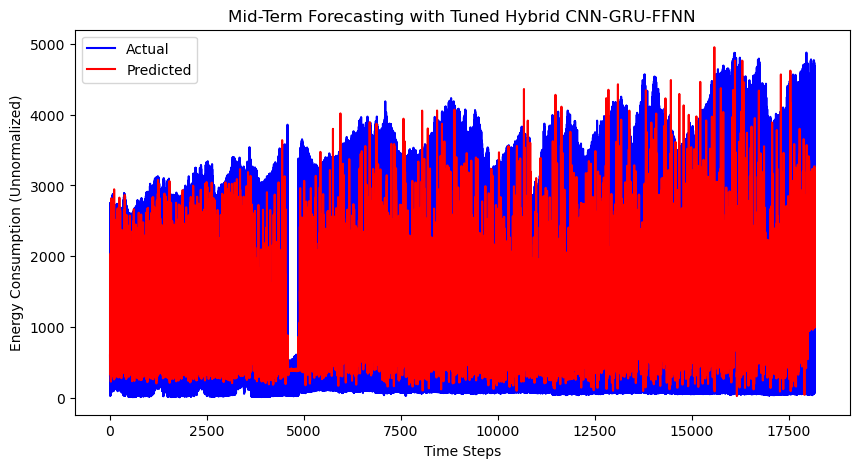

In [6]:
# Function to evaluate the models on unnormalized data
def evaluate_model(model, X, y, scaler, title):
    predictions_normalized = model.predict(X)
    predictions = scaler.inverse_transform(predictions_normalized)  # Inverse transform the predictions
    actual = scaler.inverse_transform(y.reshape(-1, 1))  # Inverse transform the actual values

    # Calculate evaluation metrics
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    mad = np.mean(np.abs(actual - np.median(predictions)))

    # Print evaluation metrics
    print(f'{title} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, MAD: {mad:.4f}')

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Energy Consumption (Unnormalized)')
    plt.legend()
    plt.show()

# Evaluate and plot the best model
evaluate_model(best_model, X_mid, y_mid, scaler, "Mid-Term Forecasting with Tuned Hybrid CNN-GRU-FFNN")

C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\raaje\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


559/559 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step
Long-Term Forecasting with Tuned Hybrid CNN-GRU-FFNN - MSE: 1964168.0720, RMSE: 1401.4878, MAE: 1100.4407, MAPE: 543.31%, MAD: 1151.6981


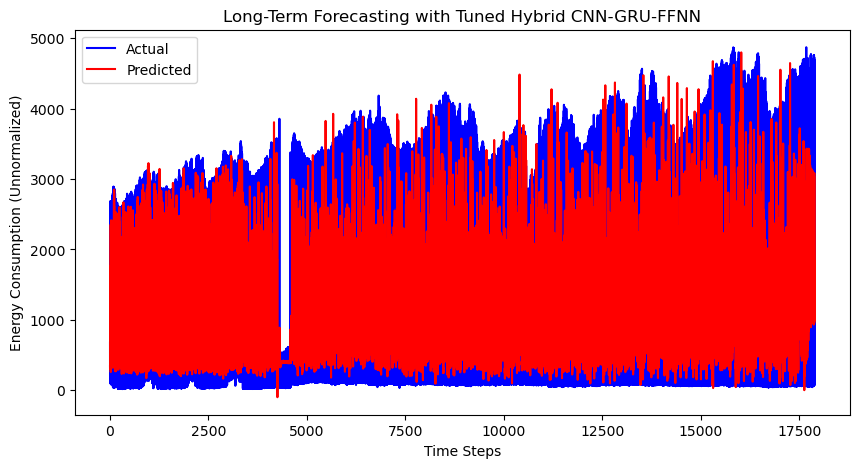

In [7]:
# Perform the search for the best model on the long-term data
tuner.search(X_long, y_long, epochs=30, validation_split=0.2)

# Get the best model for long-term forecasting
best_model_long = tuner.get_best_models(num_models=1)[0]

# Evaluate and plot the best model for long-term forecasting
evaluate_model(best_model_long, X_long, y_long, scaler, "Long-Term Forecasting with Tuned Hybrid CNN-GRU-FFNN")